



















# DAND Project 2: Investigate a Dataset
## Dat Set: Titanic Passengers List

### Start Date: 29 November 2016
### Submission Date: 30 November 2016
### Author: Victor Danila

## Questions investigated:
### - What factors made people more likely to survive?

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import io
%matplotlib inline

### Original Data Frame

In [21]:
# Import the CSV data and show the first 5 lines. 
filename = 'titanic-data.csv'
titanic_df = pd.read_csv(filename)
titanic_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Checking for Missing Values and Filling in Missing Instances  (Data Wrangling)

In [30]:
# Show columns with missing values.
print 'Columns with missing values:'
print
print titanic_df.isnull().any()
print
# Count missing instances in Age column.
print 'Number of missing instances in Age columns:', sum(titanic_df['Age'].isnull())
print 'Percent of missing instances in Age Column:', sum(1.0 * titanic_df['Age'].isnull())/len(titanic_df.index)*100
print 
# Add an Age column with rounded values.
titanic_df['Age_Rounded'] = titanic_df['Age'].round()
# Set logic for filling in missing values.
print 'Age mode grouped by Class and Gender:'
print
ref_table = titanic_df.groupby(['Pclass', 'Sex'], as_index=False)['Age_Rounded'].agg(lambda x:x.value_counts().index[0])
print ref_table



Columns with missing values:

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
Age_Rounded     True
dtype: bool

Number of missing instances in Age columns: 0
Percent of missing instances in Age Column: 0.0

Age mode grouped by Class and Gender:

   Pclass     Sex  Age_Rounded
0       1  female         35.0
1       1    male         36.0
2       2  female         24.0
3       2    male         34.0
4       3  female         18.0
5       3    male         20.0


I will fill in the missing age instances given that I will be looking how age affects survival chances. 

In [29]:
# Fill in the NaNs with values from the ref_table using the loc function: 
titanic_df.loc[(titanic_df.Pclass == 1) & (titanic_df.Sex=='female') & np.isnan(titanic_df.Age) , 'Age'] = 35
titanic_df.loc[(titanic_df.Pclass == 1) & (titanic_df.Sex=='male') & np.isnan(titanic_df.Age) , 'Age'] = 36
titanic_df.loc[(titanic_df.Pclass == 2) & (titanic_df.Sex=='female') & np.isnan(titanic_df.Age) , 'Age'] = 24
titanic_df.loc[(titanic_df.Pclass == 2) & (titanic_df.Sex=='male') & np.isnan(titanic_df.Age) , 'Age'] = 34
titanic_df.loc[(titanic_df.Pclass == 3) & (titanic_df.Sex=='female') & np.isnan(titanic_df.Age) , 'Age'] = 18
titanic_df.loc[(titanic_df.Pclass == 3) & (titanic_df.Sex=='male') & np.isnan(titanic_df.Age) , 'Age'] = 20

### Latest Data Frame (After Data Wrangling)

In [46]:
# Function that assigns passenger to an age group.
def assign_age_group(age):
    if age is not 'NaN':
        if age <= 9:
            return '0_Children'
        elif 10 <= age <= 19:
            return '1_Adolescents'
        elif 20 <= age <= 45:
            return '2_Adults'
        elif 46 <= age <=60:
            return '3_Middle Age Adults'
        elif 60 < age:
            return '4_Seniors'
        
#Create new column named 'Age Group'.
titanic_df['Age Group'] = titanic_df['Age'].apply(assign_age_group)

#Function that assigns 1 to each passanger, to be used in counting. 
def assign_num_value(value):
    return 1

#Creat new column and insert 1 on each row:
titanic_df['Count'] = titanic_df['PassengerId'].apply(assign_num_value)
#Show the updated data frame.
titanic_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Rounded,Age Group,Count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,2_Adults,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,2_Adults,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,2_Adults,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,2_Adults,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,2_Adults,1


# Part I - Data Grouped by Class and Gender

### Graph  of Survival Ratio by Class and Gender

In [52]:
# Group by Pclass and Age and take the Survived mean. 
survival_ratio_data = titanic_df.groupby(['Pclass', 'Sex',], as_index=False ) \
                                        ['Survived'].mean()
# Create new Deceased column and assign values.
deceased = survival_ratio_data['Survived'] * (-1) + 1.00
survival_ratio_data['Deceased'] = deceased
# Show table.
survival_ratio_data

,Pclass,Sex,Survived,Deceased
0,1,female,0.968085,0.031915
1,1,male,0.368852,0.631148
2,2,female,0.921053,0.078947
3,2,male,0.157407,0.842593
4,3,female,0.500000,0.500000
5,3,male,0.135447,0.864553


In [33]:
# Create table to be used for the plot. 
plot1_data = survival_ratio_data[['Survived', 'Deceased']]
# Create new index.
plot1_data.index = ['Class I - Women', 'Class I - Men', 'Class II - Women',
                    'Class II - Men', 'Class III - Women', 'Class III - Men']
# Show table.
plot1_data

,Survived,Deceased
Class I - Women,0.968085,0.031915
Class I - Men,0.368852,0.631148
Class II - Women,0.921053,0.078947
Class II - Men,0.157407,0.842593
Class III - Women,0.500000,0.500000
Class III - Men,0.135447,0.864553


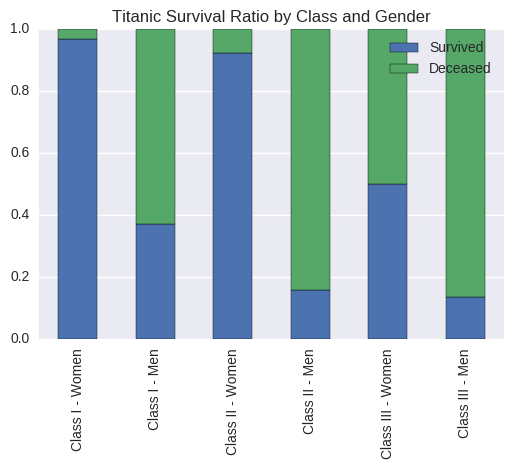

In [34]:
# Plot the Class Gender Ratio data. 
plotClassGenderRatio = plot1_data.plot(kind='bar', stacked=True,
                                       title='Titanic Survival Ratio by Class and Gender',
                                       legend=True,)

### Graph of survival numbers by class and gender

In [48]:
# Create table for plot.
plot1_1_data_df = titanic_df.groupby(['Pclass', 'Sex',], as_index=False ) \
                                    ['Count', 'Survived'].sum()
# Create new column and assign values.
plot1_1_data_df['Deceased'] = plot1_1_data_df['Count'] - \
                              plot1_1_data_df['Survived']
# Delete unnecessary columns.
plot1_1_data_df.drop('Pclass', axis=1, inplace=True)
plot1_1_data_df.drop('Sex', axis=1, inplace=True)
plot1_1_data_df.drop('Count', axis=1, inplace=True)
# Create new index.
plot1_1_data_df.index = ['Class I - Women', 'Class I - Men', 
                         'Class II - Women', 'Class II - Men', 
                         'Class III - Women', 'Class III - Men']
plot1_1_data_df

,Survived,Deceased
Class I - Women,91,3
Class I - Men,45,77
Class II - Women,70,6
Class II - Men,17,91
Class III - Women,72,72
Class III - Men,47,300


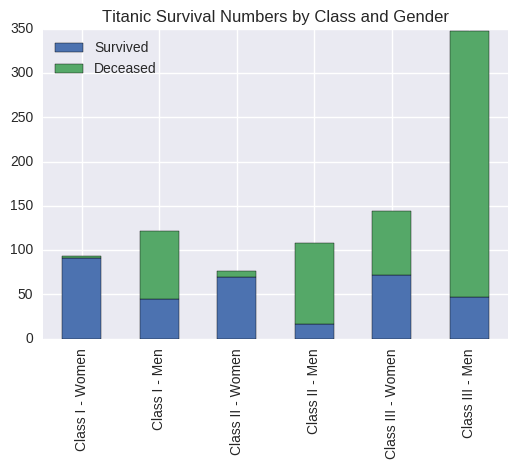

In [51]:
# Plot the Class Gender Absolute values data.
plotClassGenderAbs = plot1_1_data_df.plot(
                        kind='bar', stacked=True,
                        title='Titanic Survival Numbers by Class and Gender',
                        legend=True)

### Graph  of age frequency of passengers

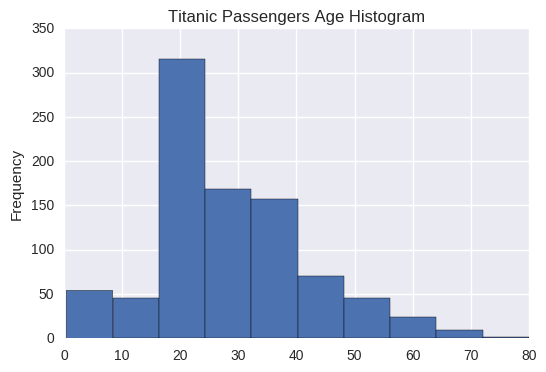

In [37]:
# Create a histogram counting the passengers age frequency.
age_hist_data = titanic_df['Age']
plotAgeHist = age_hist_data.plot(kind='hist', title='Titanic Passengers Age Histogram')

The 'Titanic Passengers Age Histogram' shows that most passengers were adults and middle age adults and the age follows a normal distribution. 

# Part II - Data Grouped by Class and Age Group

### Graph of survival ratio by class and age group

In [54]:
# Group data by Pclass and Age Group and sum Count and Survived.
age_group_survival_ratio_df = titanic_df.groupby(['Pclass', 'Age Group',], as_index=False) \
                                                ['Count', 'Survived'].sum()
# Create Survived Ration column and assign values.
age_group_survival_ratio_df['Survived Ratio'] = age_group_survival_ratio_df['Survived'] / \
                                                age_group_survival_ratio_df['Count']
# Create Deceased Ratio column and assign values. 
age_group_survival_ratio_df['Deceased Ratio'] = 1 - age_group_survival_ratio_df['Survived Ratio']
# Create Deceased column and assign values.
age_group_survival_ratio_df['Deceased'] = age_group_survival_ratio_df['Count'] - \
                                          age_group_survival_ratio_df['Survived']
# Show the table. 
age_group_survival_ratio_df

,Pclass,Age Group,Count,Survived,Survived Ratio,Deceased Ratio,Deceased
0,1,0_Children,3,2,0.666667,0.333333,1
1,1,1_Adolescents,18,15,0.833333,0.166667,3
2,1,2_Adults,133,89,0.669173,0.330827,44
3,1,3_Middle Age Adults,47,27,0.574468,0.425532,20
4,1,4_Seniors,14,3,0.214286,0.785714,11
5,2,0_Children,17,17,1.000000,0.000000,0
6,2,1_Adolescents,18,9,0.500000,0.500000,9
7,2,2_Adults,126,54,0.428571,0.571429,72
8,2,3_Middle Age Adults,20,6,0.300000,0.700000,14
9,2,4_Seniors,3,1,0.333333,0.666667,2


In [55]:
# Group by Survived Ratio and Deceased Ratio. 
plot3_data_df = age_group_survival_ratio_df[['Survived Ratio', 'Deceased Ratio']]
# Change column names.
plot3_data_df.columns = ['Survived', 'Deceased']
# Change index. 
plot3_data_df.index = ['Class I - Children', 'Class I - Adolescents', 
                       'Class I - Adults', 'Class I - Middle Age Adults', 
                       'Class I - Seniors', 'Class II - Children', 'Class II - Adolescents', 
                       'Class II - Adults', 'Class II - Middle Age Adults', 
                       'Class II - Seniors', 'Class III - Children', 'Class III - Adolescents', 
                       'Class III - Adults', 'Class III - Middle Age Adults', 
                       'Class II - Seniors'
                      ]
# Show table.
plot3_data_df

,Survived,Deceased
Class I - Children,0.666667,0.333333
Class I - Adolescents,0.833333,0.166667
Class I - Adults,0.669173,0.330827
Class I - Middle Age Adults,0.574468,0.425532
Class I - Seniors,0.214286,0.785714
Class II - Children,1.000000,0.000000
Class II - Adolescents,0.500000,0.500000
Class II - Adults,0.428571,0.571429
Class II - Middle Age Adults,0.300000,0.700000
Class II - Seniors,0.333333,0.666667


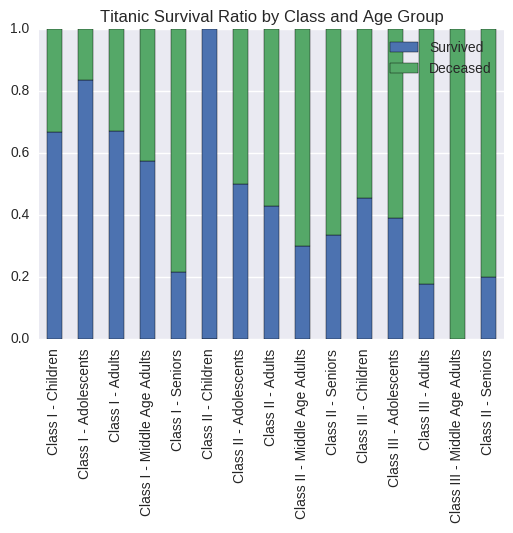

In [56]:
# Plot the survival ratio.
plotClassAgeRatio = plot3_data_df.plot(
                        kind='bar', stacked=True,
                        title='Titanic Survival Ratio by Class and Age Group',
                        legend=True
                        )

### Graph of survival numbers by class and age group

In [58]:
# Group data by Survived and Deceased.
plot4_data_df = age_group_survival_ratio_df[['Survived', 'Deceased']]
# Create new index.
plot4_data_df.index = ['Class I - Children', 'Class I - Adolescents',
                       'Class I - Adults', 'Class I - Middle Age Adults',
                       'Class I - Seniors', 'Class II - Children', 
                       'Class II - Adolescents', 'Class II - Adults', 
                       'Class II - Middle Age Adults', 'Class II - Seniors',
                       'Class III - Children', 'Class III - Adolescents', 
                       'Class III - Adults', 'Class III - Middle Age Adults', 
                       'Class II - Seniors'
                      ]
# Show table.
plot4_data_df

,Survived,Deceased
Class I - Children,2,1
Class I - Adolescents,15,3
Class I - Adults,89,44
Class I - Middle Age Adults,27,20
Class I - Seniors,3,11
Class II - Children,17,0
Class II - Adolescents,9,9
Class II - Adults,54,72
Class II - Middle Age Adults,6,14
Class II - Seniors,1,2


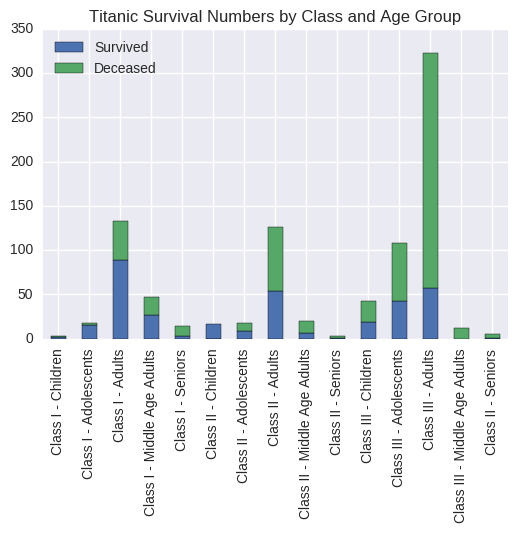

In [59]:
# Plot the Survived and Deceased data grouped by Class and Age Group.
plotClassAgeAbs = plot4_data_df.plot(kind='bar', stacked=True, title='Titanic Survival Numbers by Class and Age Group',
                      legend=True,)

# Part III - Data Grouped by Number of Siblings

### Graph of Survival Ratio by Number of Siblings

In [43]:
# Group data by SibSp which shows the number of relatives
# onboard and take the survived mean.
plot4_data = titanic_df.groupby(['SibSp'], as_index=False)['Survived'].mean()
# Show table.
plot4_data

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


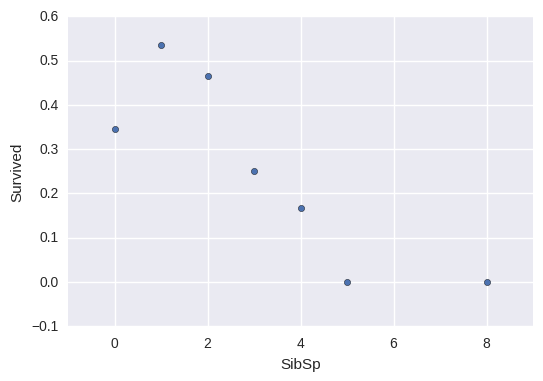

In [44]:
# Plot the survival ratio by number of siblings. 
plotSibSurvRatio = plot4_data.plot(kind='scatter', x='SibSp', y='Survived')

In [45]:
# Group data by SibSp and Sex and take
# Survived mean.
plot5_data = titanic_df.groupby(['SibSp', 'Sex'], as_index=False)['Survived'].mean()
# Show table.
plot5_data

,SibSp,Sex,Survived
0,0,female,0.787356
1,0,male,0.168203
2,1,female,0.754717
3,1,male,0.310680
4,2,female,0.769231
5,2,male,0.200000
6,3,female,0.363636
7,3,male,0.000000
8,4,female,0.333333
9,4,male,0.083333


# Conclusions

After analyzing the data it appears that the change of survival depends on the following:
1. The gender had a significant impact on the chance of survival. Women were more likely to survive than men indifferent of cabin class or age. 
2. The cabin class had a certain impact on survival change but not as clear as gender. The higher the cabin class the higher the chance of survival. 
3. The age also has a significant impact on survival. The smaller the age the bigger the survival chance got across all cabin classes. 
4. The number of siblings aboard the vessel seems to have a negative impact on the survival chance. The bigger the number of siblings the smaller the chance of survival got. 